- CNN with @tf.function and function API

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, MaxPooling2D, MaxPool2D, Dense, Flatten, BatchNormalization, AveragePooling2D, GlobalAveragePooling2D, SpatialDropout2D
from tensorflow.keras.activations import relu, softmax
from tensorflow.keras.models import Sequential
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.backend import mean
from tensorflow.keras.metrics import categorical_accuracy
from tensorflow.keras.initializers import RandomNormal
from tensorflow.keras.layers import Concatenate
from keras.initializers import random_normal
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime
import time

In [ ]:
layer = [Conv2D(16,(5,5), strides=(1,1), padding='same', activation= relu, use_bias= True),
          MaxPooling2D((3,3), strides=(1,1), padding= 'same'),
          Conv2D(32,(3,3), strides=(1,1), padding='same', activation= relu, use_bias= True),
          MaxPooling2D((3,3), strides=(1,1), padding= 'same'),
          Conv2D(64,(2,2), strides=(1,1), padding='same', activation= relu, use_bias= True),
          MaxPooling2D((2,2), strides=(1,1), padding= 'same'),
          Flatten(),
          Dense(256, activation= relu),
          Dense(10, activation= softmax)]

In [ ]:
model = Sequential(layers= layer)
opt = Adam(learning_rate= 0.001)
epochs = 3000

170500096/170498071 [==============================] - 11s 0us/step
[6]
(50000, 32, 32, 3)


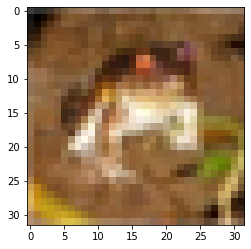

In [ ]:
(training_images, training_labels), (test_images, test_labels) = cifar10.load_data()
plt.imshow(training_images[0])
print(training_labels[0])
print(training_images.shape)

In [ ]:
training_images = training_images.reshape([-1,32,32,3])
training_images = training_images.astype("float32")
training_images = training_images/255.0
test_images = test_images.reshape([-1,32,32,3])
test_images = test_images.astype("float32")
test_images = test_images/255.0
training_labels = to_categorical(training_labels, 10)
test_labels = to_categorical(test_labels, 10)

In [ ]:
@tf.function
def train(X,y):
  with tf.GradientTape() as tape:
    logits = model(X)
    loss = categorical_crossentropy(y,logits)
  grads = tape.gradient(loss, model.trainable_variables)
  opt.apply_gradients(zip(grads, model.trainable_variables))


In [ ]:
data = tf.data.Dataset.from_tensor_slices((training_images, training_labels))
data = data.shuffle(60000).batch(128).repeat()

In [ ]:
# Set up logging.
stamp = datetime.now().strftime("%Y%m%d-%H%M%S")
logdir = 'logs/func/%s' % stamp
writer = tf.summary.create_file_writer(logdir)
start = time.time()
total_time = 0
for step, (img_batch, lbl_batch) in enumerate(data):
  if step > epochs:
    break
  tf.summary.trace_on(graph=True, profiler=True)
  train(img_batch, lbl_batch)
  with writer.as_default():
        tf.summary.trace_export(name="my_func_trace",step=0, profiler_outdir=logdir)
  if(step%100==0):
    logits = model(img_batch)
    loss = tf.keras.backend.mean(categorical_crossentropy(lbl_batch, logits))
    acc = tf.reduce_mean(tf.cast(tf.equal(tf.argmax(logits,1), tf.argmax(lbl_batch, 1)), dtype=tf.float32))
    print("Loss: {} Accuracy: {}".format(loss, acc))
    stop = time.time()
    print("took {} seconds\n".format(stop-start))
    total_time = total_time + (stop-start)
    start = time.time()
    

Loss: 8.165178298950195 Accuracy: 0.1640625
took 1.175452709197998 seconds

Loss: 1.497135877609253 Accuracy: 0.4609375
took 6.210579872131348 seconds

Loss: 1.2418545484542847 Accuracy: 0.5625
took 6.222809791564941 seconds

Loss: 1.2981982231140137 Accuracy: 0.5
took 6.289289236068726 seconds

Loss: 1.309839129447937 Accuracy: 0.5703125
took 6.633558034896851 seconds

Loss: 1.1311992406845093 Accuracy: 0.640625
took 6.182263135910034 seconds

Loss: 0.964453399181366 Accuracy: 0.640625
took 6.241414308547974 seconds

Loss: 0.936171293258667 Accuracy: 0.640625
took 6.2583677768707275 seconds

Loss: 0.8536112904548645 Accuracy: 0.7265625
took 6.507059812545776 seconds

Loss: 0.9445644021034241 Accuracy: 0.6875
took 6.210546970367432 seconds

Loss: 0.8825757503509521 Accuracy: 0.7109375
took 6.237922191619873 seconds

Loss: 0.9349455833435059 Accuracy: 0.6796875
took 6.264832258224487 seconds

Loss: 0.9442899227142334 Accuracy: 0.6640625
took 6.488150358200073 seconds

Loss: 0.8851624131

In [ ]:
print("total time with tf.function", total_time)
logits = model.predict(test_images)
#loss = tf.keras.backend.mean(categorical_crossentropy(test_labels, logits))
test_acc = tf.reduce_mean(tf.cast(tf.equal(tf.argmax(logits,1), tf.argmax(test_labels, 1)), dtype=tf.float32))
print("test_accuracy:", test_acc, "seconds")

total time with tf.function 190.37361121177673
test_accuracy: tf.Tensor(0.6929, shape=(), dtype=float32) seconds


In [ ]:
logits = model(training_images[0:1000])
loss = categorical_crossentropy(training_labels[0:1000],logits)
tf.keras.backend.mean(loss)
tf.argmax(logits,1)
acc = tf.equal(tf.argmax(logits,1), tf.argmax(training_labels[0:1000], 1))
print(tf.reduce_mean(tf.cast(acc, tf.float32)))

In [ ]:
inp_entry = tf.keras.layers.Input((32,32,3))
inp = Conv2D(16,(5,5), strides=(1,1), padding='same', activation= relu, use_bias= True)(inp_entry)
inp = MaxPooling2D((3,3), strides=(1,1), padding= 'same')(inp)
inp = Conv2D(32,(3,3), strides=(1,1), padding='same', activation= relu, use_bias= True)(inp)
inp = MaxPooling2D((3,3), strides=(1,1), padding= 'same')(inp)
inp = Conv2D(64,(2,2), strides=(1,1), padding='same', activation= relu, use_bias= True)(inp)
inp = MaxPooling2D((2,2), strides=(1,1), padding= 'same')(inp)
inp = Flatten()(inp)
inp = Dense(256, activation= relu)(inp)
out = Dense(10, activation= softmax)(inp)

model = tf.keras.Model(inp_entry, out)
opt = Adam(learning_rate= 0.001)
epochs = 3000

In [ ]:
def train(X,y):
  with tf.GradientTape() as tape:
    logits = model(X)
    loss = categorical_crossentropy(y,logits)
  grads = tape.gradient(loss, model.trainable_variables)
  opt.apply_gradients(zip(grads, model.trainable_variables))

In [ ]:
# Set up logging.
stamp = datetime.now().strftime("%Y%m%d-%H%M%S")
logdir = 'logs/func/%s' % stamp
writer = tf.summary.create_file_writer(logdir)
start = time.time()
total_time = 0
for step, (img_batch, lbl_batch) in enumerate(data):
  if step > epochs:
    break
  tf.summary.trace_on(graph=True, profiler=True)
  train(img_batch, lbl_batch)
  with writer.as_default():
        tf.summary.trace_export(name="my_func_trace",step=0, profiler_outdir=logdir)
  if(step%100==0):
    logits = model(img_batch)
    loss = tf.keras.backend.mean(categorical_crossentropy(lbl_batch, logits))
    acc = tf.reduce_mean(tf.cast(tf.equal(tf.argmax(logits,1), tf.argmax(lbl_batch, 1)), dtype=tf.float32))
    print("Loss: {} Accuracy: {}".format(loss, acc))
    stop = time.time()
    print("took {} seconds\n".format(stop-start))
    total_time = total_time + (stop-start)
    start = time.time()

print("total_time without tf.function", total_time, "seconds")

- Decorator vs leaving-out
  - with tf.function - Approx. 190 seconds.
  - without tf.function - Approx 235 seconds.



```
# This is formatted as code
```

**- DenseNet Architecture on Cifar10 dataset**

In [ ]:
# Hyperparameters
batch_size = 128
num_classes = 10
epochs = 150
l = 12
num_filter = 24
compression = 0.5
dropout_rate = 0.2
wt_decay = 0.001

In [ ]:
# Dense Block
def add_denseblock(input, num_filter = 12, dropout_rate = 0.2):
    global compression
    temp = input
    for _ in range(l):
        BatchNorm = BatchNormalization()(temp)
        rel = relu(BatchNorm)
        #Conv2D_3_3 = Conv2D(int(num_filter*compression), (3,3), use_bias=False ,padding='same', kernel_initializer=(random_normal(stddev=np.sqrt(2.0/(9*int(num_filter*compression))))))(relu)
        Conv2D_3_3 = Conv2D(int(num_filter*compression), (3,3), use_bias=False ,padding='same', kernel_initializer=(random_normal(stddev=np.sqrt(2.0/(9*int(num_filter))))))(rel)
        if dropout_rate>0:
          Conv2D_3_3 = SpatialDropout2D(dropout_rate)(Conv2D_3_3)
        concat = Concatenate(axis=-1)([temp,Conv2D_3_3])      
        temp = concat      
    return temp

In [ ]:
def add_transition(input, num_filter = 12, dropout_rate = 0.2):
    global compression
    BatchNorm = BatchNormalization()(input)
    rel = relu(BatchNorm)
    Conv2D_BottleNeck = Conv2D(int(int(input.shape[-1])*compression), (1,1), use_bias=False ,padding='same', kernel_initializer=(random_normal(stddev=np.sqrt(2.0/(9*int(num_filter*compression))))))(rel)
    #Conv2D_BottleNeck = Conv2D(int(num_filter*compression), (1,1), use_bias=False ,padding='same',kernel_initializer=(random_normal(stddev=np.sqrt(2.0/(9*int(num_filter*compression))))))(relu)
    if dropout_rate>0:
      Conv2D_BottleNeck = SpatialDropout2D(dropout_rate)(Conv2D_BottleNeck)
    avg = AveragePooling2D(pool_size=(2,2))(Conv2D_BottleNeck)
    
    return avg

In [ ]:
def output_layer(input):
    global compression
    BatchNorm = BatchNormalization()(input)
    rel = relu(BatchNorm)
    AvgPooling = AveragePooling2D(pool_size=(2,2))(rel)
    flat = Flatten()(AvgPooling)
    output = Dense(num_classes, activation='softmax')(flat)
    #output = Dense(num_classes, activation='softmax', kernel_initializer='he_normal')(flat)
    
    return output

In [ ]:
input = tf.keras.layers.Input(shape=(32,32,3))
First_Conv2D = Conv2D(int(num_filter), (3,3), use_bias=False , padding='same', kernel_initializer=(random_normal(stddev=np.sqrt(2.0/(9*num_filter)))))(input)

First_Block = add_denseblock(First_Conv2D, num_filter, dropout_rate)
First_Transition = add_transition(First_Block, num_filter, dropout_rate)

#First_Transition = merge([First_Transition,First_Conv2D], mode='concat', concat_axis=-1)

Second_Block = add_denseblock(First_Transition, num_filter, dropout_rate)
Second_Transition = add_transition(Second_Block, num_filter, dropout_rate)

#Second_Transition = Concatenate(axis=-1)([Second_Transition,First_Transition,First_Conv2D])

Third_Block = add_denseblock(Second_Transition, num_filter, dropout_rate)
Third_Transition = add_transition(Third_Block, num_filter, dropout_rate)

#Third_Transition = Concatenate(axis=-1)([Third_Transition,Second_Transition,First_Transition,First_Conv2D])

Last_Block = add_denseblock(Third_Transition,  num_filter, dropout_rate)
output = output_layer(Last_Block)

In [ ]:
model = tf.keras.Model(inputs=[input], outputs=[output])
model.summary()


Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_13 (InputLayer)           [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv2d_60 (Conv2D)              (None, 32, 32, 24)   648         input_13[0][0]                   
__________________________________________________________________________________________________
batch_normalization_57 (BatchNo (None, 32, 32, 24)   96          conv2d_60[0][0]                  
__________________________________________________________________________________________________
tf_op_layer_Relu_55 (TensorFlow [(None, 32, 32, 24)] 0           batch_normalization_57[0][0]     
____________________________________________________________________________________________

In [ ]:
# determine Loss function and Optimizer
model.compile(loss='categorical_crossentropy',
              optimizer=Adam(),
              metrics=['accuracy'])

In [ ]:
model.fit(x=training_images, y= training_labels, batch_size = 256, epochs=5, steps_per_epoch=200)

Epoch 1/5
200/200 [==============================] - 153s 764ms/step - loss: 1.8068 - accuracy: 0.3399
Epoch 2/5
200/200 [==============================] - 153s 765ms/step - loss: 1.4221 - accuracy: 0.4854
Epoch 3/5
200/200 [==============================] - 153s 765ms/step - loss: 1.2460 - accuracy: 0.5522
Epoch 4/5
200/200 [==============================] - 153s 765ms/step - loss: 1.1164 - accuracy: 0.6031
Epoch 5/5
180/200 [==========================>...] - 138s 764ms/step - loss: 1.0146 - accuracy: 0.6405


In [ ]:
model.fit(x=training_images, y= training_labels,  epochs=2, steps_per_epoch=1000)

Epoch 1/2
1000/1000 [==============================] - 192s 192ms/step - loss: 1.0395 - accuracy: 0.6340
Epoch 2/2
1000/1000 [==============================] - 192s 192ms/step - loss: 0.8832 - accuracy: 0.6876


In [ ]:
model.evaluate(x= test_images, y=test_labels)

313/313 [==============================] - 12s 37ms/step - loss: 0.8411 - accuracy: 0.7213


[0.8410952091217041, 0.7213000059127808]

- Test accuracy on cifar-10 datset is nearly 72%.